In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


Анализ данных

In [305]:
# Загрузим данные из файла
file_path = "Готовые данные.csv"
df = pd.read_csv(file_path)

# Посмотрим на первые строки и общую информацию
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   comment                               2373 non-null   object 
 1   id                                    2373 non-null   object 
 2   rating                                2373 non-null   float64
 3   Вопрос решен                          2373 non-null   int64  
 4   Нравится качество выполнения заявки   2373 non-null   int64  
 5   Нравится качество работы сотрудников  2373 non-null   int64  
 6   Нравится скорость отработки заявок    2373 non-null   int64  
 7   Понравилось выполнение заявки         2373 non-null   int64  
 8   Работа не выполнена                   2373 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 167.0+ KB


(None,
                                         comment       id  rating  \
 0                                       спасибо  2945792     5.0   
 1                                      спасибо!  3234340     5.0   
 2                                      Отлично   3380332     5.0   
 3  Благодарю за оперативное решение проблемы !   3381812     5.0   
 4         Прекрасный специалист! Побольше таких  3461991     5.0   
 
    Вопрос решен  Нравится качество выполнения заявки  \
 0             1                                    0   
 1             1                                    0   
 2             1                                    0   
 3             1                                    0   
 4             1                                    0   
 
    Нравится качество работы сотрудников  Нравится скорость отработки заявок  \
 0                                     0                                   0   
 1                                     0                                 

Очистка данных

In [306]:
df_cleaned = df.drop_duplicates(subset=["comment"]).reset_index(drop=True)

target_columns = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Работа не выполнена"
]
df_model = df_cleaned[["comment"] + target_columns]

label_distribution = df_model[target_columns].sum().sort_values(ascending=False)
df_model.shape, label_distribution

((1812, 7),
 Вопрос решен                            1470
 Понравилось выполнение заявки            690
 Нравится скорость отработки заявок       568
 Нравится качество работы сотрудников     409
 Работа не выполнена                      194
 Нравится качество выполнения заявки      181
 dtype: int64)

In [307]:
vectorizer = TfidfVectorizer(
    max_features=10000,  
    ngram_range=(1, 2),
    stop_words=None 
)

X = vectorizer.fit_transform(df_model["comment"])
Y = df_model[target_columns]

Кросс-валидация

In [308]:
def cross_val_auc(X, Y, n_splits=5):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, test_idx in cv.split(Y):  
        fold_auc = []
        X_train, X_test = X[train_idx], X[test_idx]

        for class_idx in range(Y.shape[1]):
            y_train = Y.iloc[train_idx, class_idx]
            y_test = Y.iloc[test_idx, class_idx]

            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)[:, 1]

            try:
                score = roc_auc_score(y_test, y_prob)
            except ValueError:
                score = np.nan  

            fold_auc.append(score)

        auc_scores.append(fold_auc)

    return np.array(auc_scores)

Обучение модели

In [309]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

fpr = {}
tpr = {}
roc_auc = {}
f1_scores = {}


for i, class_name in enumerate(Y.columns):
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train, Y_train.iloc[:, i])

    probs = clf.predict_proba(X_test)[:, 1]
    preds = clf.predict(X_test)

    
    fpr[i], tpr[i], _ = roc_curve(Y_test.iloc[:, i], probs)
    roc_auc[i] = auc(fpr[i], tpr[i])


    
    f1_scores[class_name] = f1_score(Y_test.iloc[:, i], preds)



mean_auc_overall = np.mean(list(roc_auc.values()))
mean_f1_overall = np.mean(list(f1_scores.values()))

print("Метрики по каждому классу:\n")
for class_name in Y.columns:
    idx = Y.columns.get_loc(class_name)
    print(f"🔹 {class_name}")
    print(f"   ROC AUC : {roc_auc[idx]:.4f}")
    print(f"   F1-score: {f1_scores[class_name]:.4f}\n")

print("🔸 Средние метрики:")
print(f"   Средний ROC AUC : {mean_auc_overall:.4f}")
print(f"   Средний F1-score: {mean_f1_overall:.4f}")



Метрики по каждому классу:

🔹 Вопрос решен
   ROC AUC : 0.8549
   F1-score: 0.8873

🔹 Нравится качество выполнения заявки
   ROC AUC : 0.6906
   F1-score: 0.3256

🔹 Нравится качество работы сотрудников
   ROC AUC : 0.9053
   F1-score: 0.7286

🔹 Нравится скорость отработки заявок
   ROC AUC : 0.9449
   F1-score: 0.8000

🔹 Понравилось выполнение заявки
   ROC AUC : 0.8245
   F1-score: 0.6667

🔹 Работа не выполнена
   ROC AUC : 0.9729
   F1-score: 0.7111

🔸 Средние метрики:
   Средний ROC AUC : 0.8655
   Средний F1-score: 0.6865


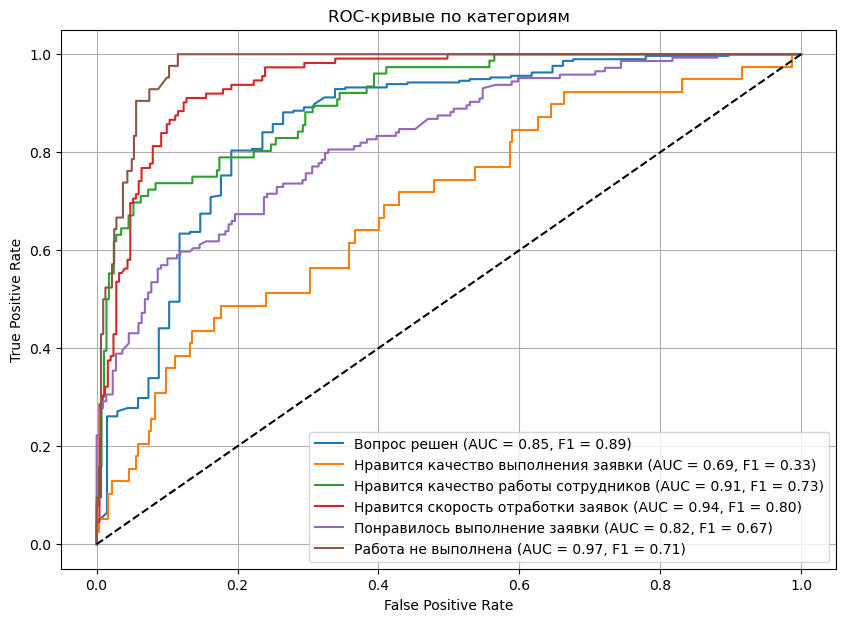

In [310]:
plt.figure(figsize=(10, 7))
for i, class_name in enumerate(Y.columns):
    plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f}, F1 = {f1_scores[class_name]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # диагональ
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по категориям")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()